In [15]:
import numpy as np
from matplotlib import pyplot as plt
from itgd import *
from sklearn.model_selection import train_test_split

In [24]:
random_state = 1
np.random.seed(random_state)

n = 1000
d = 50

Generate synthetic linear regreesion dataset:
- Generate $n \times d$ data matrix $X \sim \mathcal{N}(\mathbf{0}, \Sigma)$.
- Generate weight vector $\mathbf{w}_\text{true}$ where each $w_i \sim \mathcal{N}(0, \sigma_\text{label}^2)$.
- Generate labels using $$y_i = \mathbf{x}_i^\top\mathbf{w}_\text{true} + \xi_i$$ where $\xi_i \sim \mathcal{N}(0, \sigma_\mathbf{w}^2)$ for each $i$.

In [25]:
# Hyperparameters for clean synthetic data
w_true = np.random.normal(0, 1, d)
Sigma = np.eye(d)
label_noise_std = 1

X_clean = np.random.multivariate_normal(np.zeros(d), Sigma, size=n)
y_clean = X_clean @ w_true + np.random.normal(0, label_noise_std, n)

In [26]:
# Train/test split
X_train_clean, X_test, y_train_clean, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=random_state)
n_train = len(y_train_clean)
n_test = len(y_test)

In [27]:
# Hyperparameters for ITGD
eta = 0.1
w_init = np.zeros(d)
alpha_init = np.zeros(n_train)

In [28]:
# Corruption Hyperparameters
label_corruption_std = 50

In [35]:
# Run ITGD with epsilons from 0 to 0.5
n_eps = 50
epsilons = np.linspace(0.01, 0.499, n_eps)

# Weight matrices
eps_weights_itgd = np.zeros((n_eps, d))
eps_alpha_weights_itgd = np.zeros((n_eps, d))
eps_weights_ols_inlier = np.zeros((n_eps, d))
eps_weights_ols_full = np.zeros((n_eps, d))

for i, epsilon in enumerate(epsilons):
    # Corrupt n * epsilon samples (covariates and labels)
    num_outliers = int(epsilon * n_train)
    outlier_idx = np.random.choice(n_train, num_outliers, replace=False)
    inlier_idx = np.setdiff1d(np.arange(n_train), outlier_idx)

    X_corrupted = X_train_clean.copy()
    y_corrupted = y_train_clean.copy()

    # TODO: Add covariate corruption
    # X_corrupted[outlier_idx] += np.random.normal(0, 1, size=(num_outliers, d))


    # Corrupt weights
    #y_corrupted[outlier_idx] += np.random.normal(0, label_corruption_std, num_outliers)
    y_corrupted[outlier_idx] = 2 * np.linspace(np.min(y_corrupted), np.max(y_corrupted), num_outliers)

    # Learned weights and alphas
    w_itgd = iterative_threshold_gd_linear(X_corrupted, y_corrupted, Sigma, epsilon, eta, w_init)
    w_ols_inlier = np.linalg.pinv(X_corrupted[inlier_idx]) @ y_corrupted[inlier_idx]
    w_ols_full = np.linalg.pinv(X_corrupted) @ y_corrupted
    
    # Current algorithm requires small step size for convergence
    alpha_itgd = iterative_threshold_gd_kernel(X_corrupted, y_corrupted, Sigma, epsilon, 1e-4 * eta, alpha_init)

    # Bookkeeping
    eps_weights_itgd[i, :] = w_itgd
    eps_weights_ols_inlier[i, :] = w_ols_inlier
    eps_weights_ols_full[i, :] = w_ols_full

    eps_alpha_weights_itgd[i, :] = X_train_clean.T @ alpha_itgd

# Calculate parameter and test errors
itgd_weight_err = np.linalg.norm(eps_weights_itgd - w_true, axis=1)
itgd_alpha_err = np.linalg.norm(eps_alpha_weights_itgd - w_true, axis=1)

itgd_linear_pred_err = np.linalg.norm(X_test @ eps_weights_itgd.T - y_test[:, None], axis=0) / n_test
ols_inlier_pred_err = np.linalg.norm(X_test @ eps_weights_ols_inlier.T - y_test[:, None], axis=0) / n_test
ols_full_pred_err = np.linalg.norm(X_test @ eps_weights_ols_full.T - y_test[:, None], axis=0) / n_test

itgd_kernel_pred_err = np.linalg.norm(X_test @ eps_alpha_weights_itgd.T - y_test[:, None], axis=0) / n_test

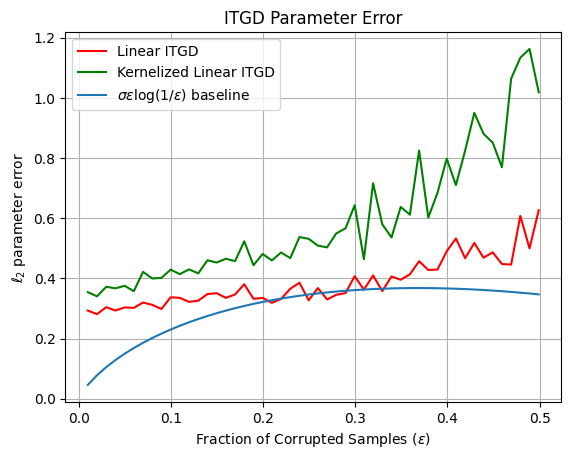

In [38]:
# Plot Parameter Errors against a baseline
plt.plot(epsilons, itgd_weight_err, color='r', label="Linear ITGD")
plt.plot(epsilons, itgd_alpha_err, color='g', label="Kernelized Linear ITGD")
plt.plot(epsilons, label_noise_std * epsilons * np.log(1/epsilons), label=f"$\\sigma\\epsilon\\log(1/\\epsilon)$ baseline")
plt.xlabel(f"Fraction of Corrupted Samples ($\\epsilon$)")
plt.ylabel(f"$\\ell_2$ parameter error")
plt.title(f"ITGD Parameter Error")
plt.legend()
plt.grid()
plt.show()

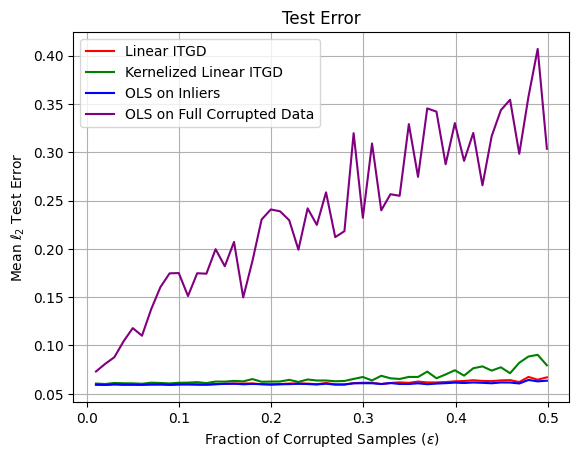

In [39]:
# Prediction Error Plots
plt.plot(epsilons, itgd_linear_pred_err, color='red', label="Linear ITGD")
plt.plot(epsilons, itgd_kernel_pred_err, color='green', label="Kernelized Linear ITGD")
plt.plot(epsilons, ols_inlier_pred_err, color='blue', label="OLS on Inliers")
plt.plot(epsilons, ols_full_pred_err, color='purple', label="OLS on Full Corrupted Data")

plt.xlabel(f"Fraction of Corrupted Samples ($\\epsilon$)")
plt.ylabel("Mean $\\ell_2$ Test Error")
plt.title("Test Error")
plt.legend()
plt.grid()
plt.show()